In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import Sequential

import os
import cv2
import glob

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
{0:"햄버거", 1:"치킨",2:"파스타",3:"피자",4:"돈까스",5:"스시",6:"떡볶이"}
class_names = ["햄버거", "치킨", "파스타", "피자", "돈까스", "스시","떡볶이"]




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/food/food0119.zip",  "r") as target_file:
  target_file.extractall("/content/drive/MyDrive/food/food0119_2/")

In [56]:
# DATA ROOT DIR 설정
DATA_ROOT_DIR = os.path.join('/content/drive/MyDrive/food/food0119_2') 
label_name_list = os.listdir(DATA_ROOT_DIR)

In [57]:
import glob
import cv2

image_list=[]
label_list=[]

# 경로 지정
for label_name in label_name_list:
    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list=glob.glob(file_path + "/*.*")
    
    # 폴더 별로 반복문 돌리기
    for img_file in img_file_list:
        src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
        src_img = cv2.resize(src_img, dsize=(128,128)) # 사이즈 조절
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환
        
        image_list.append(src_img) # X값
        label_list.append(float(label_name)) # Y값

In [58]:
# list에 담겼는지 확인
print(len(image_list),len(label_list))

#25044 25044

28078 28078


In [59]:
X_train, X_test, y_train, y_test =train_test_split(np.array(image_list),
                                                   np.array(label_list),
                                                   test_size=0.2,
                                                   stratify=np.array(label_list)) # label을 비율에 맞게 설정

In [60]:
# 정규화
X_train= X_train.astype(np.float32) /255.0
X_test= X_test.astype(np.float32) /255.0

In [61]:
tr_gen=ImageDataGenerator(rotation_range=10,
                           width_shift_range=0.3,
                           height_shift_range=0.3,
                           zoom_range= 0.1)

idg_tr= tr_gen.flow(X_train, y_train, batch_size=128, shuffle=True)

In [62]:
# 모바일넷
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [63]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/food/model0119.h5")

model.add(Dense(256, activation="relu" ,name="dense_4"))
model.add(Dropout(0.5,name="Dropout_3"))
model.add(Dense(7, activation="softmax",name="dense_5"))

In [65]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())


model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 64)                65600     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [66]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [67]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
#                               patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
#                              )


start_time = datetime.now()

hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128) #callbacks=[earlystopping]

end_time = datetime.now()
print('elapsed time = ', end_time-start_time)

Epoch 1/50
176/176 [==============================] - 45s 242ms/step - loss: 2.7599 - accuracy: 0.1703 - val_loss: 1.6991 - val_accuracy: 0.3524
Epoch 2/50
176/176 [==============================] - 41s 231ms/step - loss: 2.0899 - accuracy: 0.2429 - val_loss: 1.4900 - val_accuracy: 0.5084
Epoch 3/50
176/176 [==============================] - 42s 236ms/step - loss: 1.8304 - accuracy: 0.3108 - val_loss: 1.2687 - val_accuracy: 0.6563
Epoch 4/50
176/176 [==============================] - 42s 238ms/step - loss: 1.5893 - accuracy: 0.4001 - val_loss: 1.0146 - val_accuracy: 0.7455
Epoch 5/50
176/176 [==============================] - 42s 237ms/step - loss: 1.3549 - accuracy: 0.4999 - val_loss: 0.7752 - val_accuracy: 0.8063
Epoch 6/50
176/176 [==============================] - 42s 237ms/step - loss: 1.1475 - accuracy: 0.5836 - val_loss: 0.6024 - val_accuracy: 0.8387
Epoch 7/50
176/176 [==============================] - 42s 237ms/step - loss: 0.9539 - accuracy: 0.6657 - val_loss: 0.4913 - val_ac

In [68]:
# evaluation
model.evaluate(X_test, y_test)


# 0118 사진 추가 전 : loss: 0.0773 , accuracy: 0.9862
# 0119 사진 추가 후 : loss: 0.2260 - accuracy: 0.9672
# 0119 은닉층 3-> 4 : loss: 0.3110 - accuracy: 0.9435 사진25078 25078
# 0119 은닉층 3-> 4 : loss: 0.3110 - accuracy: 0.9435 사진28078 28078

176/176 [==============================] - 3s 15ms/step - loss: 0.3215 - accuracy: 0.9464


[0.32149603962898254, 0.9464031457901001]

In [71]:
model.save('model0119_D4_fixed.h5')

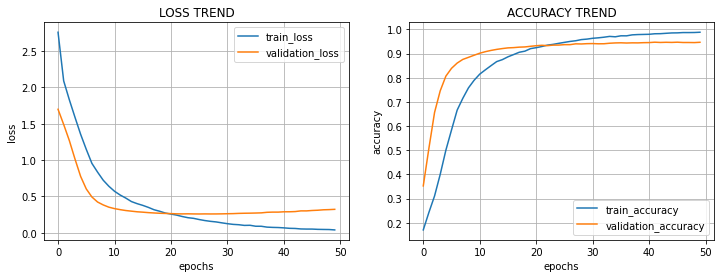

In [70]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("LOSS TREND")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='validation_loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("ACCURACY TREND")
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='validation_accuracy')
plt.legend(loc='best')
     

In [ ]:
#내가 찍은 돈까스
test_img10 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/KakaoTalk_20230117_154648765.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img10= cv2.resize(test_img10, dsize=(128,128)) # 사이즈 조절
test_img10 = cv2.cvtColor(test_img10, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

test_img10=test_img10 /255.0

pred10 = model.predict(test_img10.reshape(-1, 128,128,3))
score10=tf.nn.softmax(pred10)

# print("{:.2f}percnet의 확률로 {class_names[class_index]}입니다.".format( 100*np.max(score10)))
print(score10)

error: ignored

In [ ]:
#교촌치킨
test_img11 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/KakaoTalk_20230117_154723479.jpg", cv2.IMREAD_COLOR) # 컬러이미지로 가져오기
test_img11= cv2.resize(test_img11, dsize=(128,128)) # 사이즈 조절
test_img11 = cv2.cvtColor(test_img11, cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환

test_img11=test_img11 /255.0

pred11 = model.predict(test_img11.reshape(-1,128,128,3))
score11=tf.nn.softmax(pred11)


{0:"햄버거", 1:"치킨",2:"파스타",3:"피자",4:"돈까스",5:"떡볶이",6:"스시"}
class_names = ["햄버거", "치킨", "파스타", "피자", "돈까스", "떡볶이","스시"]


print("======================================")
for i in range(len(pred11)):
    class_index = np.argmax(pred11[i])
    print(class_name[class_index],"일 확률은 {:.2f}percnet입니다.".format(100*np.max(score11)))
    print("{:.2f}% 확률로".format(100*np.max(score11)),class_names[class_index],"입니다")

error: ignored

In [ ]:

# 이미지 불러오기
src_img1 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/for_test/8.jpg", cv2.IMREAD_COLOR)


#넘파이 배열로 불러옴
print(type(src_img1), src_img1.shape)



# RGB로 색상순서변환
dst_img1 = cv2.cvtColor(src_img1, cv2.COLOR_BGR2RGB)


# 테스트하기 위해서 이미지 가공
dst_img1 = cv2.resize(dst_img1, dsize=(128, 128))

print(dst_img1.shape)

# 정규화
dst_img1 = dst_img1 / 255.0


<class 'numpy.ndarray'> (194, 259, 3)
(128, 128, 3)


In [ ]:
test_image_list = []

test_image_list.append(dst_img1)

test_image_array = np.array(test_image_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
test_image_array.shape

(1, 128, 128, 3)

In [ ]:

pred = model.predict(test_image_array)

1/1 [==============================] - 0s 17ms/step


In [ ]:
# 스시 31퍼센트로 적중
score=tf.nn.softmax(pred)
print(score*100)

tf.Tensor([[11.47015  11.47015  11.47015  11.47015  11.47015  11.47015  31.179098]], shape=(1, 7), dtype=float32)


In [ ]:
## 주현씨 pred 코드

In [72]:
# 이미지 불러오기, 색상변환, 크기조정, 정규화
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
pred_img_list = []
pred_img_name_list = glob.glob('/content/drive/MyDrive/Colab Notebooks/for_test/predict/*.*')
for i in range(len(pred_img_name_list)):
    src_img = cv2.imread(pred_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    pred_img_list.append(src_img)
len(pred_img_list)

36

In [73]:
pred_img_array = np.array(pred_img_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
pred_img_array.shape

(36, 128, 128, 3)

In [74]:
pred = model.predict(pred_img_array)

2/2 [==============================] - 0s 15ms/step


In [75]:
class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'tteokbokki', 'sushi']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(str(i+1) + '번째 : ' + class_name[class_index], pred[i].max())

1번째 : sushi 1.0
2번째 : sushi 1.0
3번째 : sushi 1.0
4번째 : sushi 1.0
5번째 : sushi 1.0
6번째 : chicken 1.0
7번째 : chicken 0.99999976
8번째 : pasta 0.9999976
9번째 : tteokbokki 0.89232916
10번째 : tteokbokki 1.0
11번째 : pizza 0.9999721
12번째 : pizza 0.9999969
13번째 : tteokbokki 0.9999999
14번째 : porkcutlet 1.0
15번째 : pasta 1.0
16번째 : pizza 0.99999285
17번째 : tteokbokki 1.0
18번째 : pasta 0.9932499
19번째 : tteokbokki 1.0
20번째 : pasta 1.0
21번째 : pasta 0.9931846
22번째 : porkcutlet 0.9999999
23번째 : chicken 0.54424995
24번째 : porkcutlet 0.99999964
25번째 : pizza 1.0
26번째 : burger 0.6596889
27번째 : pasta 0.9999987
28번째 : pasta 0.9999974
29번째 : pizza 0.999997
30번째 : pasta 0.98753625
31번째 : porkcutlet 0.84201556
32번째 : pasta 1.0
33번째 : pizza 0.9999981
34번째 : pasta 1.0
35번째 : pizza 0.99999595
36번째 : pasta 1.0


In [76]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(str(i+1) + '번째')
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

1번째
[6 0 4 1 3 2 5]
예측값 :  sushi 1.0
예측값 :  burger 9.35847e-16
예측값 :  porkcutlet 3.24702e-16
2번째
[6 4 0 1 3 2 5]
예측값 :  sushi 1.0
예측값 :  porkcutlet 1.9854694e-16
예측값 :  burger 3.2444555e-17
3번째
[6 4 0 1 3 2 5]
예측값 :  sushi 1.0
예측값 :  porkcutlet 3.171937e-08
예측값 :  burger 1.8248204e-09
4번째
[6 4 0 1 3 2 5]
예측값 :  sushi 1.0
예측값 :  porkcutlet 2.407592e-09
예측값 :  burger 2.3514881e-09
5번째
[6 4 0 1 3 2 5]
예측값 :  sushi 1.0
예측값 :  porkcutlet 2.5036428e-09
예측값 :  burger 1.6339748e-09
6번째
[1 6 5 0 4 3 2]
예측값 :  chicken 1.0
예측값 :  sushi 2.3237844e-11
예측값 :  tteokbokki 9.003422e-12
7번째
[1 4 6 5 0 3 2]
예측값 :  chicken 0.99999976
예측값 :  porkcutlet 7.8790585e-08
예측값 :  sushi 7.6497074e-08
8번째
[2 0 5 4 3 1 6]
예측값 :  pasta 0.9999976
예측값 :  burger 1.3054533e-06
예측값 :  tteokbokki 6.540929e-07
9번째
[5 2 1 3 4 0 6]
예측값 :  tteokbokki 0.89232916
예측값 :  pasta 0.050024908
예측값 :  chicken 0.019968124
10번째
[5 2 1 0 3 6 4]
예측값 :  tteokbokki 1.0
예측값 :  pasta 7.317864e-11
예측값 :  chicken 9.250218e-12
11번째
[3 2 5 0 1 6 4

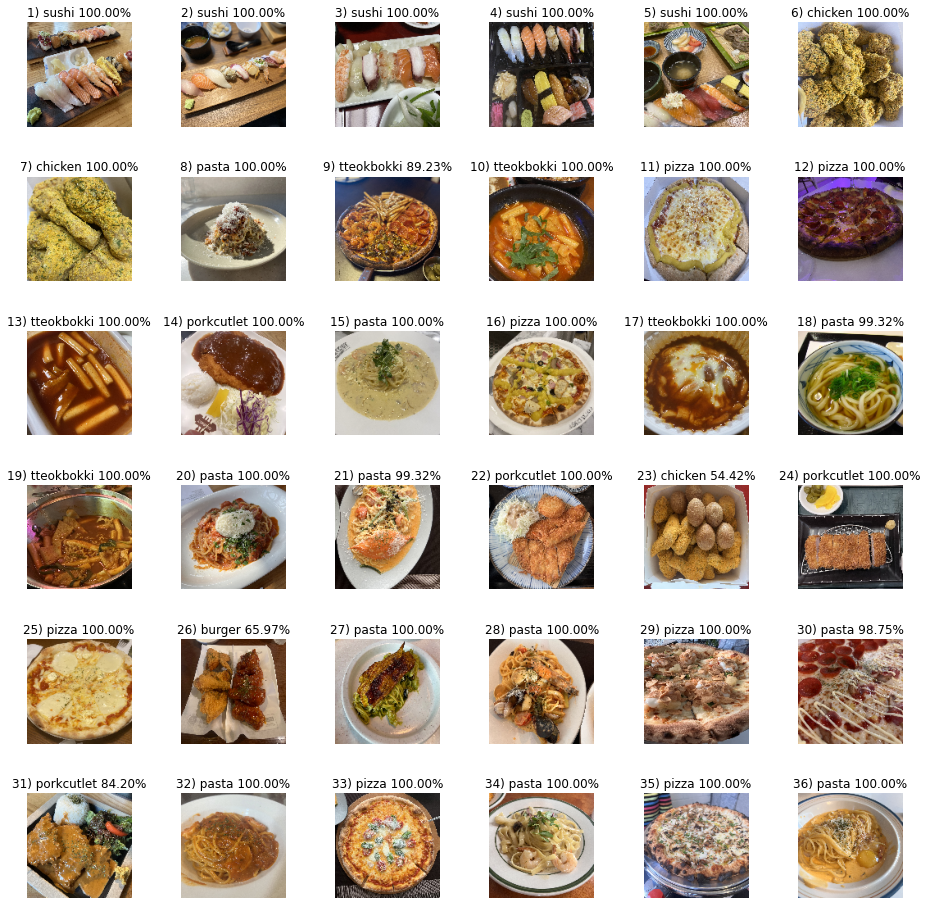

In [78]:
plt.figure(figsize=(13,13))

for i in range(len(pred)):
    plt.subplot(round(len(pred)/6), 6, i+1)
    class_index = np.argmax(pred[i])
    strTitle = str('{0:0.2f}'.format(100*max(pred[i]))) + '%'
    plt.title(str(i+1) + ') ' + class_name[class_index] + ' ' + strTitle) 
    plt.imshow(pred_img_list[i])
    plt.axis('off')
plt.tight_layout()

In [96]:
class_name

['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'tteokbokki', 'sushi']

array([[9.35846999e-16, 4.21045817e-17, 3.45772224e-19, 5.21457305e-18,
        3.24702007e-16, 1.52759773e-19, 1.00000000e+00],
       [3.24445548e-17, 5.13030279e-18, 6.41138581e-20, 3.29155121e-18,
        1.98546945e-16, 7.89332899e-21, 1.00000000e+00],
       [1.82482041e-09, 2.17023247e-10, 1.39234848e-11, 1.33650355e-10,
        3.17193702e-08, 4.27499616e-12, 1.00000000e+00],
       [2.35148812e-09, 2.97125990e-10, 2.37366533e-11, 2.57125904e-10,
        2.40759190e-09, 2.16086767e-11, 1.00000000e+00],
       [1.63397484e-09, 4.48367593e-10, 3.07054451e-11, 2.51432736e-10,
        2.50364285e-09, 1.91840328e-11, 1.00000000e+00],
       [5.60492581e-12, 1.00000000e+00, 1.31309267e-14, 2.11587692e-12,
        5.07191164e-12, 9.00342214e-12, 2.32378439e-11],
       [1.92240925e-08, 9.99999762e-01, 1.00980668e-09, 1.47525050e-08,
        7.87905847e-08, 3.24440776e-08, 7.64970736e-08],
       [1.30545334e-06, 7.57385976e-09, 9.99997616e-01, 1.15694583e-08,
        4.19461429e-07, 6

In [ ]:
# flask

In [87]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request

def get_prediction(img_bytes):
  img = image.open(io.BytesIO(image_bytes))
  img = ##test##(img).unsqueeze(0).to(device)

  with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs,1)
    imshow(img.cpu().data[0], title="예측결과 : "+ class_name[pred[0]])

  return class_name[pred[0]]

In [89]:


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_names': class_name})
        return jsonify({'class_names': class_name})

In [90]:
run_with_ngrok(app)
app.run()

#anaconda로 돌리기

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://b78d-34-73-44-118.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


ERROR:__main__:Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.8/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.8/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-89-bdddabf6cae9>", line 12, in predict
    class_name = get_prediction(image_bytes=image_bytes)
TypeError: get_pred

NameError: ignored